<a href="https://colab.research.google.com/github/nvnagendra/nv/blob/master/O'Reilly_Class_Clustering_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
#Import ML libraries
from sklearn.cluster import KMeans, AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram, linkage, ward
from sklearn.preprocessing import StandardScaler

In [ ]:
#Import Python libraries
import scipy.stats as scs
import numpy as np
import numpy.random as npr
import pandas as pd
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime

#Import and Analyze Data

In [ ]:
#Download data from Yahoo Finance
start = datetime(2017, 7, 16)
end = datetime(2021, 4, 8)
symbols = ['AAPL', 'TSLA', 'MSFT', 'IBM','GS','MS','AMZN', 'MA', 'GM', 'GME'] 
data = pdr.get_data_yahoo(symbols, start, end)

In [ ]:
#Need to check for null values to avoid processing issues
data.isnull().values.any()

False

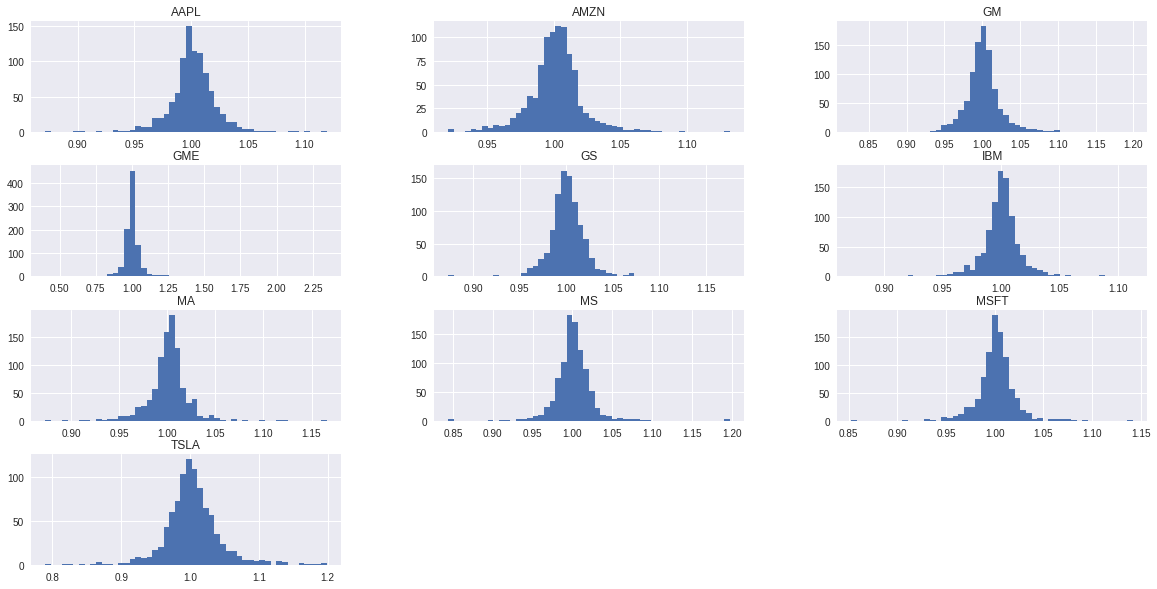

In [ ]:
#Calculate daily returns and plot the histogram
rets = data['Adj Close']/data['Adj Close'].shift(1)
rets = rets.dropna()
rets.hist(bins=50, figsize = (20, 10));

In [ ]:
#Compute the annualized covariance matrix 
covmatrix = rets.cov() * 252 #Covariance of an asset with itself is its variance (i.e. the square of its standard deviation or volatility)
covmatrix

,AAPL,AMZN,GM,GME,GS,IBM,MA,MS,MSFT,TSLA
AAPL,0.110960,0.068910,0.049867,0.054751,0.060034,0.045229,0.070157,0.066686,0.075893,0.092114
AMZN,0.068910,0.101745,0.030559,0.024261,0.040039,0.034104,0.056586,0.043430,0.070736,0.080828
GM,0.049867,0.030559,0.164402,0.074524,0.088344,0.060539,0.069120,0.093333,0.049863,0.077125
GME,0.054751,0.024261,0.074524,2.381581,0.068091,0.071091,0.027952,0.053617,0.036646,0.093825
GS,0.060034,0.040039,0.088344,0.068091,0.115901,0.057424,0.069816,0.110261,0.057726,0.071788
IBM,0.045229,0.034104,0.060539,0.071091,0.057424,0.082177,0.056542,0.064718,0.047616,0.045532
MA,0.070157,0.056586,0.069120,0.027952,0.069816,0.056542,0.107791,0.080435,0.073458,0.079183
MS,0.066686,0.043430,0.093333,0.053617,0.110261,0.064718,0.080435,0.133011,0.064915,0.072090
MSFT,0.075893,0.070736,0.049863,0.036646,0.057726,0.047616,0.073458,0.064915,0.091501,0.085433
TSLA,0.092114,0.080828,0.077125,0.093825,0.071788,0.045532,0.079183,0.072090,0.085433,0.425983


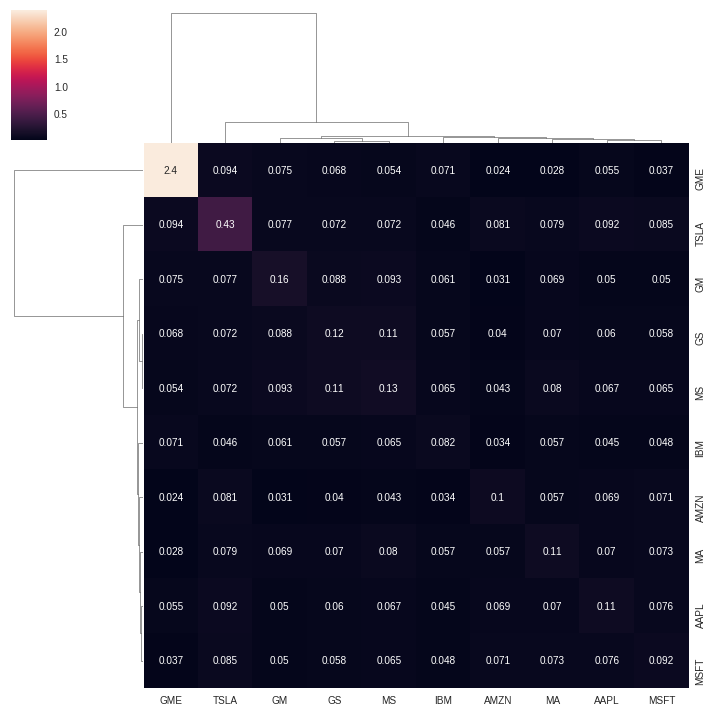

In [ ]:
#Visualize the covariance matrix
sns.clustermap(covmatrix, annot=True);

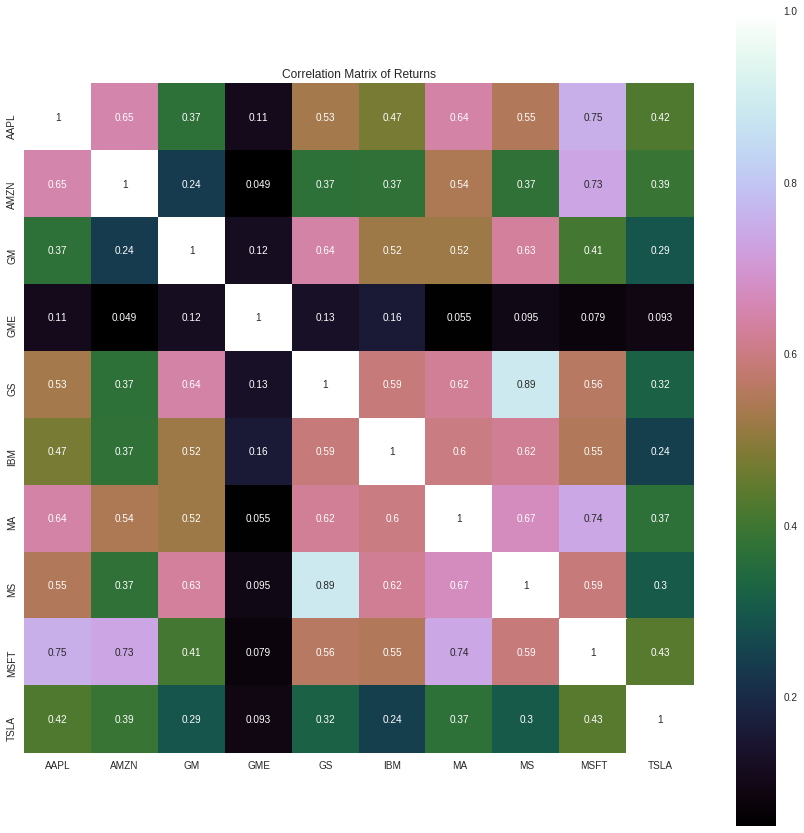

In [ ]:
#Compute and use a heatmap visualize the correlation matrix
corrmatrix = rets.corr()
plt.figure(figsize=(15, 15))
plt.title ('Correlation Matrix of Returns')
sns.heatmap(corrmatrix, vmax=1, square=True, annot=True, cmap='cubehelix');

#Build Clusters

In [ ]:
#Calculate annual returns and volatilities of stocks. These will be the two features of our model
model = pd.DataFrame()
model['Returns'] = data['Adj Close'].pct_change().mean()*252
model['Volatility'] = data['Adj Close'].pct_change().std()*np.sqrt(252) #volatility scales with the square root of time
model.head()

,Returns,Volatility
AAPL,0.399256,0.333107
AMZN,0.367527,0.318975
GM,0.250629,0.405465
GME,1.605358,1.543237
GS,0.171365,0.340442


In [ ]:
#Standardize features so that each column/feature has a zero mean and unit variance
standardized_model = StandardScaler().fit_transform(model)
standardized_model = pd.DataFrame(standardized_model, columns=model.columns, index=model.index)
standardized_model.head()

,Returns,Volatility,Cluster
AAPL,-0.158854,-0.422468,0.106000
AMZN,-0.233052,-0.461111,0.106000
GM,-0.506428,-0.224612,-0.953998
GME,2.661705,2.886521,2.225996
GS,-0.691794,-0.402410,-0.953998


In [ ]:
#Build K-Means Clustering Model
k_means = KMeans(n_clusters=5, random_state=1) #Instantiate K-Means Object with a guess for the number of clusters
k_means.fit(standardized_model) # Use the fit method to find the clusters
pair_trades = model #Create a new data frame for analyzing stock pairs
pair_trades['Cluster'] = k_means.labels_ #Gives the cluster label (numbers have no semantic meaning)
pair_trades.sort_values(by=['Cluster']) #Sort data frame by cluster number

,Returns,Volatility,Cluster
TSLA,0.844756,0.652674,0
AAPL,0.399256,0.333107,1
AMZN,0.367527,0.318975,1
MA,0.346406,0.328315,1
MSFT,0.390445,0.302491,1
GME,1.605358,1.543237,2
GM,0.250629,0.405465,3
GS,0.171365,0.340442,3
MS,0.241284,0.364707,3
IBM,0.054807,0.286665,4


#Visualize Clusters with Dendograms

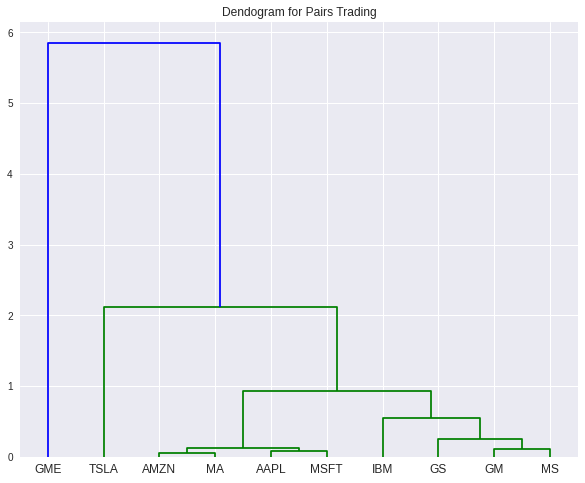

In [ ]:
dist = linkage(standardized_model, method='ward') #This one line creates hierarchical clusters. Ward minimizes the variance of merged clusters
plt.figure(figsize=(10,8))
dendrogram(dist, labels=standardized_model.index)
plt.title('Dendogram for Pairs Trading')
plt.show()

In [ ]:
#Create Hierarchical Clusters
agg_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.8, linkage='ward') #Use distance metric to create clusters
agg_cluster.fit(standardized_model)
pair_trades_agg = model
pair_trades_agg['Cluster'] = agg_cluster.labels_
pair_trades_agg.sort_values(by=['Cluster'])

,Returns,Volatility,Cluster
GM,0.250629,0.405465,0
GS,0.171365,0.340442,0
IBM,0.054807,0.286665,0
MS,0.241284,0.364707,0
AAPL,0.399256,0.333107,1
AMZN,0.367527,0.318975,1
MA,0.346406,0.328315,1
MSFT,0.390445,0.302491,1
TSLA,0.844756,0.652674,2
GME,1.605358,1.543237,3
